# Assignment 1 Amazon - Final

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
from scipy.stats import zscore
%matplotlib inline

### Read raw test data that was created in Stage0

In [48]:
amazon = pd.read_csv('../amazon_data/raw_data_test.csv')
print(amazon.shape)

(91000, 14)


### Restructure helpful score
After the first submission, I changed the helpful score to be more lenient and slightly higher (more strict) when considering the helful denominator.  

In [49]:
amazon['helpful'] = (amazon['helpScore']>=.85) & (amazon['HelpfulnessDenominator']>4)
# print(amazon['helpful'])

### Remove NaN
I also removed helpScores that were NaN

In [50]:
amazon = amazon[np.isfinite(amazon['helpScore'])]
print(amazon.shape)

(47770, 14)


### This view provides the first five lines of the data

In [51]:
print(amazon.head())
print(amazon['helpful'].mean())

    Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0       181267        413866  413867  B0026KPDG8  A3F8AMXZFG76OY   
1        13808        365696  365697  B003ENHSC8  A1OH76AX20G0BX   
5       353519        529250  529251  B0014DZQA6  A3SH3ZVXS16IBL   
6        41797        457780  457781  B001CHJ01A  A3BAMQO2TEG296   
10      412433        149737  149738  B005H6FF3Y   A7WV4HI6C8WRJ   

                            ProfileName  HelpfulnessNumerator  \
0                        Brenda Persson                     2   
1   Bank Of America "Hoping for Purity"                     3   
5                            Jeff Jones                     4   
6                       Dorothy "njsyd"                     1   
10                   Edward A. Woodward                    12   

    HelpfulnessDenominator  Score        Time  \
0                        2      5  1280102400   
1                        7      5  1216252800   
5                        6      1  1310256000   
6   

### Feature extraction on natural language data - 
This step creates a large matrix. It was the code that was used for a previous in-class assignment.¶
Using NLTK and k-means clustering, I tried to see if there was a way to cluster the two groups and distinguish the differences in common words between helpful and not helpful scores. It was not very useful, and the process of tokenizing and clustering took a long time. I can see why hashing is so useful.


In [52]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

### A hashing method is used to create matrix that is smaller in size and easier to work with.

In [53]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

/Users/hubideal/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(47770, 131072)


### This code creates a pickle file so we can treat the training and test set the same way.

In [54]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [55]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

I kept this to show the different types of features I created.  Some of these worked and others did not.  The final ones that I kept worked consistently well.  

In [56]:
amazon['reviewLen'] = amazon['Text'].str.len()
amazon['summaryLen'] = amazon['Summary'].str.len()
amazon['wordCount'] = amazon['Text'].str.split().apply(len)

amazon['wordArray'] = amazon['Text'].str.split()
amazon['wordArrayLen'] = amazon['wordArray'].str.len()
amazon['userIdLen'] = amazon['UserId'].str.len()
amazon['idLen'] = amazon['Id']
amazon['profileLen'] = amazon['ProfileName'].str.len()
amazon['zScore'] = amazon['Score']
amazon['avgWord'] = amazon['reviewLen']/amazon['wordCount']

I often tried to see if the length of the summary made a difference.  It usually did not.  

In [57]:
amazon['summaryLen'].fillna(0, inplace=True)
print(np.any(np.isnan(amazon['summaryLen'])))

False


I also checked the length of the profile.  Also, it did not help.  

In [58]:
amazon['profileLen'].fillna(0, inplace=True)
print(np.any(np.isnan(amazon['profileLen'])))

False


### Auxilary verbs
The presence of auxilary verbs usually means that the writer is using a passive voice.  It helped a little, but it was not the most helpful.  

In [59]:
def word_counter(text):
    counter=0
    for word in text:
        if word == "is" or word == 'are' or word == "was" or word == "were" or word == "can" or word == "could" or word == "will" or word == "would" or word == "become" or word == "have" or word == "has" or word == "had":
            counter=counter+1
    return counter

amazon['wordCount'] = amazon['wordArray'].apply(word_counter)
amazon['passivePer'] = amazon['wordCount'] / amazon['wordArrayLen']

### Capitalism words
after reading several reviews, I noticed that some common words were related to "bought", "taste", "good", etc.  The TDIDF matrix probably took care of a lot of this, but it did help my performance a little.  

In [60]:
def word_capitalize(text):
    counter=0
    for word in text:
        #if word == 'tea' or word == 'get' or word == 'years' or word == 'oil' or word == 'cat' or word == 'quality' or word == 'milk' or word == 'less' or word == 'brand' or word == 'give' or word == 'lot' or word == 'stuff' or word == 'ingredients' or word == 'back':
        if  word == 'love' or word == 'taste' or word =='liked' or word =="n't" or word =='great' or word =='good' or word =='flavors' or word =='product' or word =='very' or word =='using' or word =='just' or word =='trying' or word =='buy' or word =='food' or word =='make' or word =='order' or word =='price' or word =='eating' or word =='time' or word =='best' or word =='really' or word =='only' or word =='amazon' or word =='little' or word =='stores' or word =="'ve" or word =='better' or word =='because' or word =='did' or word =='does' or word =="'m" or word =='any' or word =='br' or word =='br' or word =='verified' or word =='purchased': 
        #word == 'I' or word == 'you' or word == 'my' or word == 'like' or word == 'good' or word == 'one' or word == 'food' or word == 'all' or word == 'more' or word == 'very' or word == 'product' or word == 'taste' or word == 'out' or word == 'me' or word == 'flavor' or word == 'tea' or word == 'great' or word == 'coffee' or word == 'get' or word == 'up' or word == 'use' or word == 'only' or word == 'no' or word == 'much' or word == 'we' or word == 'little' or word == 'time' or word == 'love' or word == 'My' or word == 'too' or word == 'make' or word == 'tried' or word == 'Amazon' or word == 'find' or word == 'best' or word == 'better' or word == 'water' or word == 'price' or word == 'eat' or word == 'used' or word == 'dog' or word == 'buy' or word == 'now' or word == 'first' or word == 'try' or word == 'found' or word == 'We' or word == 'sugar' or word == 'cup' or word == 'then' or word == 'made' or word == 'over' or word == '2' or word == 'our' or word == 'day' or word == 'years' or word == 'oil' or word == 'chocolate' or word == 'cat' or word == 'know' or word == 'box' or word == 'bought' or word == 'think' or word == 'store' or word == 'go' or word == 'quality' or word == 'want' or word == 'recommend' or word == 'milk' or word == 'less' or word == 'mix' or word == 'never' or word == 'brand' or word == 'without' or word == 'every' or word == 'You' or word == 'sweet' or word == 'give' or word == 'lot' or word == 'again' or word == 'drink' or word == 'stuff' or word == 'order' or word == 'ingredients' or word == 'back' or word == 'got' or word == 'tastes' or word == '1' or word == 'makes' or word == 'say':
            counter=counter+1
                
    return counter

amazon['wordCapitalize'] = amazon['wordArray'].apply(word_capitalize)
amazon['capitalism'] = amazon['wordCapitalize'] / amazon['wordArrayLen']


In [61]:
# amazon['summaryLen'] = zscore(amazon['summaryLen'])
# amazon['profileLen'] = zscore(amazon['profileLen'])

### Few Features
I only had four features in the end.  I tried adding more, but it did not perform as well. 

In [62]:
# features from Amazon.csv to add to feature set
# amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[[ 'Score', 'avgWord', 'passivePer', 'capitalism']]
print(X_quant_features.head(10))
print(type(X_quant_features))

    Score   avgWord  passivePer  capitalism
0       5  5.277778    0.055556    0.111111
1       5  5.714286    0.142857    0.095238
5       1  5.354839    0.021505    0.032258
6       5  5.476190    0.047619    0.000000
10      1  5.389764    0.047244    0.035433
12      3  5.165217    0.086957    0.043478
14      5  6.064516    0.064516    0.064516
15      5  5.123711    0.051546    0.092784
16      3  5.065217    0.130435    0.086957
21      5  5.230769    0.076923    0.115385
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix
Note: This creates a CSR Matrix. Horizontally stacked so we can concatenate horizontally (sparse matrix) and combine the hstack from the bag of words and horizontally conatenate that. Add them to two columns using the sparse data structure.

In [63]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(47770, 131076)


### Create `X`, scaled matrix of features

##### Note:  Nomralize everything on the same scale.  Use the standard scaler which takes an input matrix.  the two new columns that are added are the same as the count of the words.  

In [64]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(47770, 131076)


### create `y`, vector of Labels

In [65]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

For the semester, I used Perceptron most of the time.  It was usually the highest model.  The Logistic linear model was the second.  I also tried to focus on the Ridge Regression, but I continually went back to perceptron. In the third line (commented out) you can see the parameters I used for the perceptron model.  

In [66]:
# # MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron', eta0=2, max_iter=37, alpha=12)
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
prc = joblib.load('prc.pkl')

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Pos': 5681, 'Neg': 42089, 'TP': 2640, 'TN': 37442, 'FP': 4647, 'FN': 3041, 'Accuracy': 0.83906217291186935, 'Precision': 0.36228900782214901, 'Recall': 0.46470691779616263, 'desc': 'prc'}


### ROC plot to compare performance of various models and fits

Below, I plot the performance of the perceptron model.  For this submission I increased recall but lost a little (very little) in the precision.  

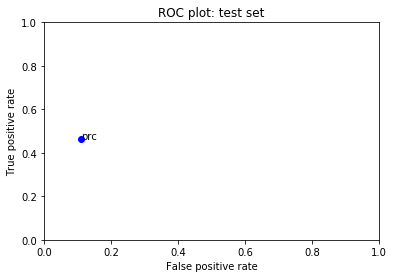

In [67]:
fits = [prc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()